In [44]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

NUM_BITS = 29
COMPARE_BITS = 10
ERROR_THRESHOLD = 0.80 

simulator = AerSimulator()

In [45]:
def prepare_alice_circuit(bits, bases):
    qc = QuantumCircuit(NUM_BITS, NUM_BITS)
    # 0 = Z-basis, 1 = X-basis
    for i in range(NUM_BITS):
        if bits[i] == 1:
            qc.x(i)
        if bases[i] == 1:
            qc.h(i)
    return qc

def add_bob_measurements(qc, bases):
    for i in range(NUM_BITS):
        if bases[i] == 1:
            qc.h(i)
        qc.measure(i, i)
    return qc

def get_bits_from_counts(counts):
    measured_string = list(counts.keys())[0]
    bits = [int(bit) for bit in reversed(measured_string)]
    return bits

In [ ]:
import hashlib
from typing import List

def privacy_amplification(key: List[int], compression_ratio: float = 0.5) -> List[int]:
    key_length = len(key)
    if key_length == 0:
        return []

    final_length = int(key_length * compression_ratio)
    
    if final_length < 1:
        return key
        
    block_size = key_length // final_length
    final_key = []

    print(f"  PA: Original Key Length: {key_length} bits.")
    print(f"  PA: Condensing to Final Key Length: {final_length} bits.")
    
    for i in range(final_length):
        start_index = i * block_size
        condensed_bit = key[start_index]
        for j in range(1, block_size):
            if start_index + j < key_length:
                condensed_bit ^= key[start_index + j]
        final_key.append(condensed_bit)
        
    return final_key

In [47]:
def run_bb84_protocol(eavesdropper=False):
    # --- ALICE PREPARATION ---
    alice_bits = np.random.randint(2, size=NUM_BITS)
    alice_bases = np.random.randint(2, size=NUM_BITS) # 0=Z, 1=X
    alice_qc = prepare_alice_circuit(alice_bits, alice_bases)
    alice_qc.barrier()
    
    # --- EVE'S INTERCEPTION ---
    if eavesdropper:
        eve_bases = np.random.randint(2, size=NUM_BITS)
        eve_measure_qc = alice_qc.copy()
        
        add_bob_measurements(eve_measure_qc, eve_bases)
        
        t_qc_eve = transpile(eve_measure_qc, simulator, coupling_map=None) 
        eve_job = simulator.run(t_qc_eve, shots=1)
        eve_bits = get_bits_from_counts(eve_job.result().get_counts())
        
        bob_qc = prepare_alice_circuit(eve_bits, eve_bases)
        bob_qc.barrier()
    else:
        bob_qc = alice_qc
        
    # --- BOB'S MEASUREMENT ---
    bob_bases = np.random.randint(2, size=NUM_BITS)
    add_bob_measurements(bob_qc, bob_bases)
    
    # Simulate
    t_qc_bob = transpile(bob_qc, simulator, coupling_map=None)
    bob_job = simulator.run(t_qc_bob, shots=1)
    bob_bits = get_bits_from_counts(bob_job.result().get_counts())
    
    # --- SIFTING ---
    sifted_alice_bits = []
    sifted_bob_bits = []
    
    for i in range(NUM_BITS):
        if alice_bases[i] == bob_bases[i]:
            sifted_alice_bits.append(alice_bits[i])
            sifted_bob_bits.append(bob_bits[i])

    num_sifted_bits = len(sifted_alice_bits)
    print(f"Total bits sent: {NUM_BITS}")
    print(f"Bits with matching bases (sifted): {num_sifted_bits}")

    # --- ERROR ESTIMATION ---
    if num_sifted_bits < COMPARE_BITS:
        print("Sifting yielded too few bits to compare. Aborting.")
        return 1.0, None

    compare_alice = sifted_alice_bits[:COMPARE_BITS]
    compare_bob = sifted_bob_bits[:COMPARE_BITS]
    
    errors = 0
    for i in range(COMPARE_BITS):
        if compare_alice[i] != compare_bob[i]:
            errors += 1
            
    error_rate = errors / COMPARE_BITS
    print(f"Comparing first {COMPARE_BITS} sifted bits...")
    print(f"  Alice's sample: {compare_alice}")
    print(f"  Bob's sample:   {compare_bob}")
    print(f"  Errors found: {errors} -> QBER: {error_rate * 100:.1f}%")

    # KEY GENERATION & POST-PROCESSING ---
    if error_rate < ERROR_THRESHOLD:
        raw_secret_key = sifted_bob_bits[COMPARE_BITS:]
        key_length = len(raw_secret_key)
        
        if key_length == 0:
            print("\nFAILURE: Raw key length is 0 after comparison. Protocol aborted.")
            return error_rate, None


        final_key = privacy_amplification(raw_secret_key, compression_ratio=0.7)

        print(f"\nSUCCESS: Error rate ({error_rate * 100:.1f}%) is below threshold ({ERROR_THRESHOLD * 100}%).")
        print(f"Raw secret key established (before PA): {key_length} bits.")
        print(f"Final Secret Key established (after PA): {len(final_key)} bits.")
        
        return error_rate, final_key
    else:
        print(f"\nFAILURE: Error rate ({error_rate * 100:.1f}%) is too high!")
        print("Protocol aborted. Key discarded.")
        return error_rate, None

In [48]:
print("NO EAVESDROPPER")
qber_no_eve, key_no_eve = run_bb84_protocol(eavesdropper=False)

NO EAVESDROPPER
Total bits sent: 29
Bits with matching bases (sifted): 13
Comparing first 10 sifted bits...
  Alice's sample: [np.int32(1), np.int32(0), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(0), np.int32(0), np.int32(1), np.int32(1)]
  Bob's sample:   [1, 0, 1, 1, 1, 1, 0, 0, 1, 1]
  Errors found: 0 -> QBER: 0.0%
  PA: Original Key Length: 3 bits.
  PA: Condensing to Final Key Length: 2 bits.

SUCCESS: Error rate (0.0%) is below threshold (80.0%).
Raw secret key established (before PA): 3 bits.
Final Secret Key established (after PA): 2 bits.


In [49]:
print("WITH EAVESDROPPER")
qber_eve, key_eve = run_bb84_protocol(eavesdropper=True)

WITH EAVESDROPPER
Total bits sent: 29
Bits with matching bases (sifted): 19
Comparing first 10 sifted bits...
  Alice's sample: [np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(1), np.int32(1), np.int32(0), np.int32(0), np.int32(0), np.int32(1)]
  Bob's sample:   [0, 0, 0, 0, 0, 1, 1, 1, 0, 1]
  Errors found: 3 -> QBER: 30.0%
  PA: Original Key Length: 9 bits.
  PA: Condensing to Final Key Length: 6 bits.

SUCCESS: Error rate (30.0%) is below threshold (80.0%).
Raw secret key established (before PA): 9 bits.
Final Secret Key established (after PA): 6 bits.


--- 4-Bit Example Circuit (Alice -> Bob) ---


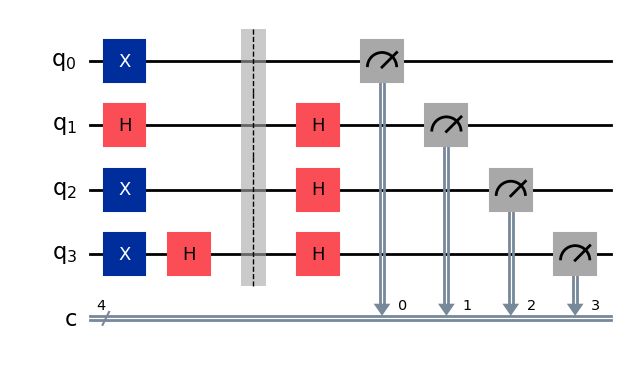

In [50]:
# --- Example: Alice -> Bob (No Eve) ---
small_bits = [1, 0, 1, 0]
small_alice_bases = [0, 1, 0, 1] 
small_bob_bases =   [0, 1, 1, 0] 

qc_alice_bob = QuantumCircuit(4, 4)
# Alice prepares
qc_alice_bob.x(0) 
qc_alice_bob.h(1) 
qc_alice_bob.x(2) 
qc_alice_bob.x(3)
qc_alice_bob.h(3) 
qc_alice_bob.barrier()
# Bob measures
qc_alice_bob.h(1) 
qc_alice_bob.h(2) 
qc_alice_bob.h(3) 
for i in range(4):
    qc_alice_bob.measure(i, i)

print("--- 4-Bit Example Circuit (Alice -> Bob) ---")
qc_alice_bob.draw('mpl')


--- 4-Bit Example Circuit (Alice -> Eve -> Bob) ---


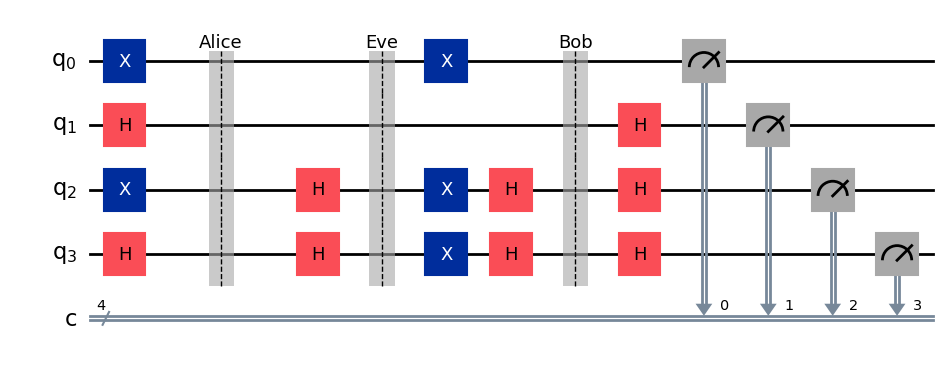

In [51]:
qc_alice_eve_bob = QuantumCircuit(4, 4)
qc_alice_eve_bob.x(0)
qc_alice_eve_bob.h(1)
qc_alice_eve_bob.x(2)
qc_alice_eve_bob.h(3)
qc_alice_eve_bob.barrier(label="Alice")

eve_bases = [0, 0, 1, 1]
qc_alice_eve_bob.h(2)
qc_alice_eve_bob.h(3)
qc_alice_eve_bob.barrier(label="Eve")

eve_bits = [1, 0, 1, 1]
qc_alice_eve_bob.x(0)
qc_alice_eve_bob.x(2)
qc_alice_eve_bob.h(2)
qc_alice_eve_bob.x(3)
qc_alice_eve_bob.h(3)
qc_alice_eve_bob.barrier(label="Bob")

qc_alice_eve_bob.h(1)
qc_alice_eve_bob.h(2)
qc_alice_eve_bob.h(3)
for i in range(4):
    qc_alice_eve_bob.measure(i, i)

print("\n--- 4-Bit Example Circuit (Alice -> Eve -> Bob) ---")
qc_alice_eve_bob.draw('mpl')

In [52]:
NUM_SIMULATIONS = 50
qber_no_eve_list = []
qber_eve_list = []

print(f"Running {NUM_SIMULATIONS} simulations for each scenario...")

for i in range(NUM_SIMULATIONS):
    # Run without Eve
    err_no_eve, _ = run_bb84_protocol(eavesdropper=False)
    qber_no_eve_list.append(err_no_eve)
    
    # Run with Eve
    err_eve, _ = run_bb84_protocol(eavesdropper=True)
    qber_eve_list.append(err_eve)

print("Simulations complete.")

Running 50 simulations for each scenario...
Total bits sent: 29
Bits with matching bases (sifted): 15
Comparing first 10 sifted bits...
  Alice's sample: [np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(0), np.int32(1), np.int32(0), np.int32(0), np.int32(1)]
  Bob's sample:   [1, 1, 1, 1, 1, 0, 1, 0, 0, 1]
  Errors found: 0 -> QBER: 0.0%
  PA: Original Key Length: 5 bits.
  PA: Condensing to Final Key Length: 3 bits.

SUCCESS: Error rate (0.0%) is below threshold (80.0%).
Raw secret key established (before PA): 5 bits.
Final Secret Key established (after PA): 3 bits.
Total bits sent: 29
Bits with matching bases (sifted): 13
Comparing first 10 sifted bits...
  Alice's sample: [np.int32(1), np.int32(1), np.int32(0), np.int32(1), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(1), np.int32(0)]
  Bob's sample:   [1, 1, 0, 1, 0, 0, 0, 1, 1, 0]
  Errors found: 1 -> QBER: 10.0%
  PA: Original Key Length: 3 bits.
  PA: Condensing to Final Key Length: 2 bi

KeyboardInterrupt: 

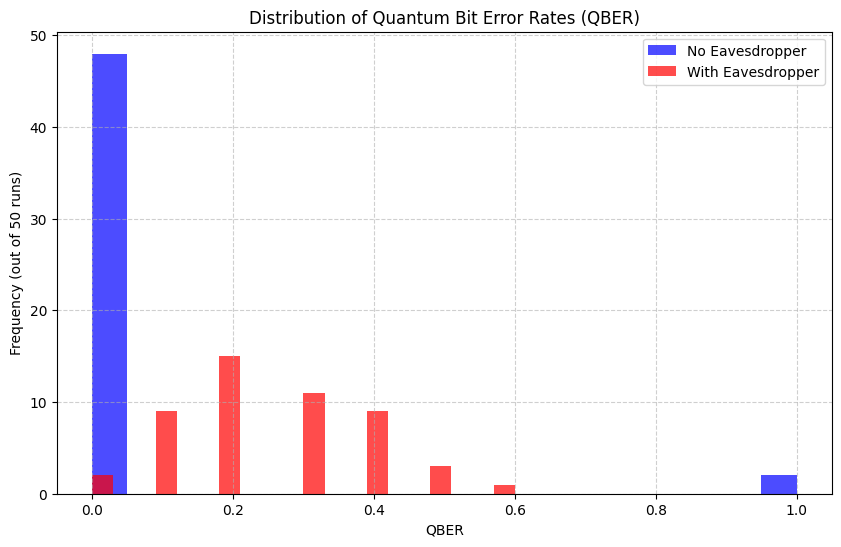

In [ ]:
# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(qber_no_eve_list, bins=20, alpha=0.7, label='No Eavesdropper', color='blue')
plt.hist(qber_eve_list, bins=20, alpha=0.7, label='With Eavesdropper', color='red')

plt.title('Distribution of Quantum Bit Error Rates (QBER)')
plt.xlabel('QBER')
plt.ylabel('Frequency (out of 50 runs)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()